In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from colossus.lss import peaks
from colossus.lss import bias
from scipy.misc import derivative
from scipy.integrate import quad
from scipy.integrate import odeint

cosmo = cosmology.setCosmology('WMAP3')

# 디폴트 파라미터 논문에 나온 대로 수정
cosmo.H0 = 73
cosmo.Om0 = 0.24
cosmo.Ob0 = 0.042
cosmo.sigma8 = 0.74
cosmo.n_s = 0.95

omega_r = 1e-5 # ??

# Figure 1

In [2]:
# 적분 함수 정의
def my_integ(f,a,b,arg=20010907):
    n = int(1e4)
    h = (b - a) / n
    xarr = np.linspace(a,b,n)
    if (arg==20010907):
        farr = f(xarr)*h
        return sum(farr)
    else:
        farr = f(xarr,arg)*h
        return sum(farr)

def my_integ_inf(f,a,b=np.inf,arg=20010907):
    n = int(1e3)
    h = 1 / n
    tarr = np.linspace(0,1,n)
    pram = a + tarr/(1-tarr)
    if (arg==20010907):
        farr = f(pram) * (1-t)**-2 *h
        return sum(farr)
    else:
        farr = f(pram,arg) * (1-t)**-2 *h
        return sum(farr)

In [3]:
# WMAP 3-yr results
Ot0=1 # total density param
Ob0 = 0.042 # density param in baryon
Om0 = 0.24 # density param in matter
Ol0 = 0.76 # density param in dark matter
f = 0.001 # star formation efficiency
H0 = 73 # Hubble constant; km/s/Mpc
h = 0.73 # Hubble parameter
rho_m = 9.9*1e-30 # total mess density of background universe ; g/cm^3

def E(z):
    return np.sqrt(Ol0+Om0*(1+z)**3)

def H(z): 
    '''
    hubble parameter을 계산해주는 함수
    
    parameters:
                z: np.array() or float
    ----------------------------------------------------
    return: H(z) 
            dtype = float,
            unit: km/s/Mpc)
    '''
    return H0 * E(z) * 3.24e-20/3.17e-8


def M_crit(z, T_min=1e3, T_max=1e4, mu=1.2):
    '''
    M_crit 계산 함수
    
    parameters:
                z: float or np.array()
                T_min, T_max, mu: float
    ----------------------------------------------------
    return: 주어진 T에서 z에 따른 min, max M_crit
            dtype = tupple (2*len(z). [0]:M_min , [1]:M_max ),
            unit: solar mass
    '''
    # print('m_crit',z)
    M_min=1e8*(mu/0.6)**(-3/2)*(T_min/1e4)**(3/2)*((1+z)/10)**(-3/2)
    M_max=1e8*(mu/0.6)**(-3/2)*(T_max/1e4)**(3/2)*((1+z)/10)**(-3/2)
    return M_min, M_max 

def Mn_ST(M, z):
    '''
    F_col 계산에 쓰일 피적분함수
    
    parameters:
                M: float
                z: float
    ----------------------------------------------------
    return: M * ST halo function (M,z) dM
            dtype: np.array
            unit: (Mpc/h)^(-3)
    '''
    r = peaks.lagrangianR(M)
    return mass_function.massFunction(M/h, z, q_out='dndlnM', model='sheth99') # unit: (Mpc/h)^(-3)

def F_col(z): # 수정
    '''
    collapsed fraction of mass 계산함수. f를 M에 따라 적분합니다
    
    parameters:
                z: float or np.array()
    ----------------------------------------------------
    return: z에 따른 F_col값 array (z의 함수...)
            dtype: np.array,
            unit: Solar mass * (Mpc/h)^(-3))
    '''
    #print('f_col',z)
    M_min, M_max= M_crit(z)
    #return 1/rho_m*my_integ(Mn_ST,M_min,M_max,z)
    return 1/rho_m*quad(Mn_ST,M_min,M_max,args=(z,))[0]


def Pop3_SFR(z, omega_b0 = 0.042, omega_m0 = 0.24, f_ = 0.001, h_=0.73):
    '''
    star formation rate 계산 함수
    
    parameters:
                z: np.array() or float
    ----------------------------------------------------
    return: z에 따른 Star formation rate array
            dtype: np.array,
            unit: Solar mass * (yr)^(-1) * (Mpc)^(-3)
    '''
    dfdz = derivative(F_col,z,dx=1e-6)
    dzdt = H(z) * (1+z) # 단위: yr^-1 # 이것도 맞는 생각일까??
    result = rho_m * Ob0 / Om0 * f * abs(dfdz) * abs(dzdt)
    return result

Text(0, 0.5, 'SFR [$M_\\odot$ $yr^{-1}$ $Mpc^{-3}$]')

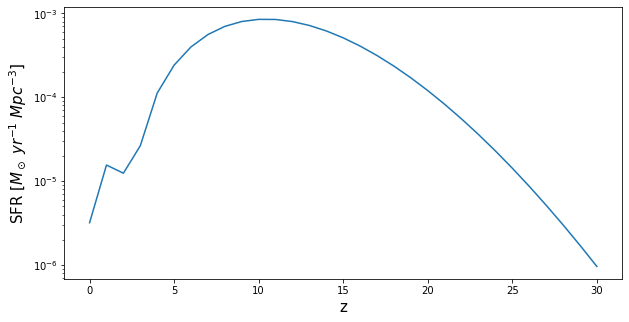

In [27]:
z=np.arange(0,31)
SFR = []
for i in range(len(z)):
    SFR.append(Pop3_SFR(z[i]))

plt.figure(figsize=(10,5))
plt.plot(z,SFR)
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('SFR [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]',fontsize=15)
#plt.yticks([1e-6,1e-5,1e-4,1e-3])

# Figure 2

In [5]:
# R을 내부함수로... M dependence 존재 

delta_c = 1.69 #the threshold overdensity for collapse; dim = x

def Q_ion(z,w):
    return np.exp(-(z-6)**2 / w)

def n_ST(M, z, h_=0.73):
    temp = mass_function.massFunction(M/h, z, q_out='dndlnM', model='sheth99')
    result = temp / M
    #print('n_ST', temp, 'result', result)
    #return result
    return result

def n(z):
    M_min, M_max= M_crit(z)
    result = quad(n_ST,M_min,M_max,args=(z,))[0]
    # print(result)
    return result

def R_z(z,w):
    r = (3 / (4*np.pi) * Q_ion(z,w) / n(z))**(1/3) # Mpc/h
    if r<1e-2:
        return 1e-2
    else:
        return r # Mpc / h

def g(z):
    # 완.
    Om = Om0 * (1+z)**3 / E(z)**2
    Ol = Ol0 / E(z)**2
    return 5/2 * Om / (Om**(4/7) - Ol + (1 + Om/2) * (1 + Ol/70))

def D(z):
    D = g(z) / (g(0) * (1+z))
    return D

def nu(M,z):
    r = peaks.lagrangianR(M) # dim: Mpc
    D = g(z) / (g(0) * (1+z))
    sigma = np.sqrt(cosmo.sigma(r,z))
    # return del_c / (D * sigma) # dim 계산
    return delta_c / (D * sigma) # dim 계산

def b(M,z): # M의 질량을 가진 halo가 z에 따라 얼마나 있는지
    # bias, dim: Solar Mass
    return 1 + (nu(M,z)**2 - 1) / delta_c

def mybias(M,z):
    a = 0.707
    b = 0.5
    c = 0.6
    nu_p = a * nu(M,z)**2 # nu_prime^2
    result = 1 + 1/delta_c * (nu_p + b * nu_p**(1-c) - nu_p**c / np.sqrt(a)/(nu_p**c + b * (1-c) * (1-c/2)))
    return result
    
def mybias0(M,z):
    a = 0.707
    b = 0.5
    c = 0.6
    nu_p = a * nu(M,z)**2 # nu_prime^2
    result = 1 + D(z)/delta_c * (nu_p + b * nu_p**(1-c) - nu_p**c / np.sqrt(a)/(nu_p**c + b * (1-c) * (1-c/2)))
    return result

def b_avg_integ(M,z):
    return Mn_ST(M,z)*mybias0(M,z)
    #return Mn_ST(M,z)*bias.haloBias(M/h, model = 'jing98',z=z)
    # return Mn_ST(M,z)*bias.haloBias(M/h, model = 'cole89',z=z)

def b_avg(z):
    # 완
    M_min, M_max= M_crit(z)
    a = quad(b_avg_integ,M_min,M_max,args=(z))[0]
    b = quad(Mn_ST,M_min,M_max,args=(z))[0]
    return a / b

def xi_hh(z,w):
    r = R_z(z,w)
    xi_mm = cosmo.correlationFunction(r, z) # 여기 들어가는 r이 Mpc/h 맞음.......
    return b_avg(z)**2*xi_mm

def p_ion(z,w):
    return Q_ion(z,w)*(1+xi_hh(z,w)) # 이온화된 볼륨에 실제 헤일로에 의해 결정되는 값 보정?

def SFR14(z,p_ion):
    return(1-p_ion)*Pop3_SFR(z)

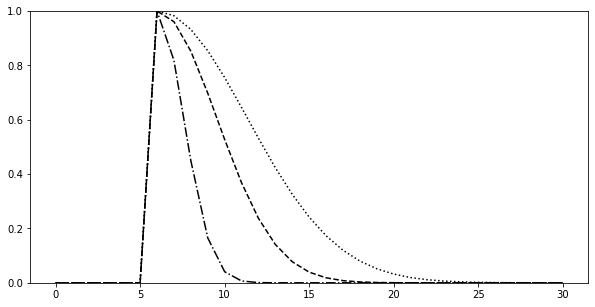

In [29]:
w =[57.,25.,5.] 
Qe=Q_ion(z,w[0])
Qi=Q_ion(z,w[1])
Ql=Q_ion(z,w[2])

peak = np.where(Qe == max(Qe))[0][0]
for i in range(0,peak):
    Qe[i]=0
    Qi[i]=0
    Ql[i]=0



Q=[Qe, Qi, Ql]
line=['dotted','dashed','dashdot']
plt.figure(figsize=(10,5))
plt.ylim([0,1])
for i in range(len(line)):
    plt.plot(z,Q[i],linestyle=line[i],c='k')

In [31]:
p_ion_early = np.zeros(len(z))
p_ion_inter = np.zeros(len(z))
p_ion_late = np.zeros(len(z))
p_ions = [p_ion_early, p_ion_inter, p_ion_late]
for i in range(len(w)):
    for j in range(len(z)):
        p_ions[i][j]=p_ion(z[j],w[i])

SFR_ealry= np.zeros(len(z))
SFR_inter= np.zeros(len(z))
SFR_late= np.zeros(len(z))
SFRs = [SFR_ealry, SFR_inter, SFR_late]
for i in range(len(w)):
    for j in range(len(z)):
        SFRs[i][j]=SFR14(z[j],p_ions[i][j])

Text(0, 0.5, 'SFR [$M_\\odot$ $yr^{-1}$ $Mpc^{-3}$]')

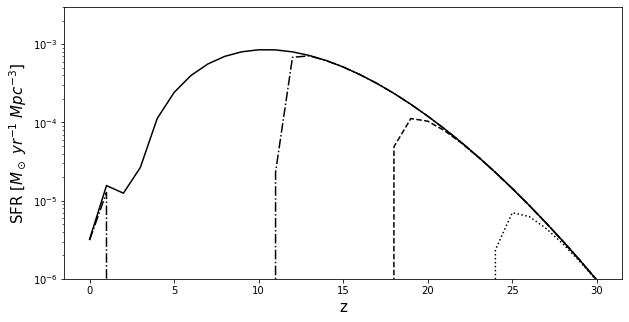

In [32]:
plt.figure(figsize=(10,5))
plt.plot(z,SFR,c='k')
plt.plot(z,SFRs[0],':',c='k')
plt.plot(z,SFRs[1],'--',c='k')
plt.plot(z,SFRs[2],'-.',c='k')
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylim([1e-6,3*1e-3])
plt.ylabel('SFR [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]',fontsize=15)
#plt.savefig('figure2(b)_ns1')

# Figure 5

In [6]:
n_b = 2e-7 # cm**-3; present day의 barion number density
a_b = 2.6 * 10e-13 # cm**3 / s
f_esc = 0.7
eta_ion = 9e4

def C(z):
    if z>=6:
        return 1+9*((1+z)/7)**(-2)
    else:
        return 10

def dndz(z,w): # pop3로 한다
    scale=1.989e33 / ((3.086e24)**3 * 3.154e7) * 3.086e19 # 단위 변환
    return (1./rho_m) * (Om0 / Ob0) * f_esc * eta_ion* SFR14(z,w) * abs(H(z) * (1+z)) * scale

def dQdz(Q,z,w):
    dtdz = 1 / (H(z) * (1+z))
    return dndz(z,w)-a_b*n_b*C(z)*Q**2*(1+z)**3*abs(dtdz)* 3.086e19

'''
def dndz(z): # pop3로 한다
    return (1./rho_m) * (Om0 / Ob0) * f_esc*eta_ion*Pop3_SFR(z) * abs(H(z) * (1+z)) * 1.989e33 / ((3.086e24)**3 * 3.154e7) * 3.086e19

def dQdz(Q,z,w):
    dtdz = 1 / (H(z) * (1+z))
    return dndz(z)-a_b*n_b*C(z)*Q**2*(1+z)**3*abs(dtdz)* 3.086e19
'''

def new_Q_ion(w):
    Q = 1
    zarr=np.linspace(0,30)
    result = odeint(dQdz,Q,zarr,args=(w,))
    return result

C:\Users\SAMSUNG\AppData\Roaming\Python\Python39\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


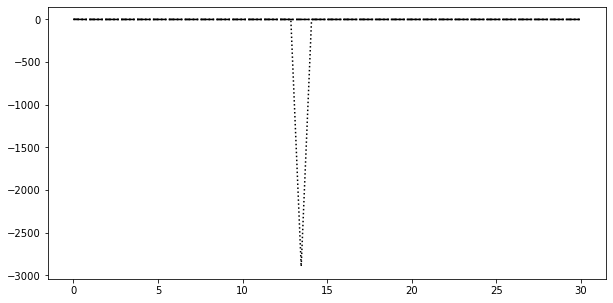

In [7]:
zarr=np.linspace(0,30)
w =[57.,25.,5.] 

Qe=new_Q_ion(w[0])
Qi=new_Q_ion(w[1])
Ql=new_Q_ion(w[2])

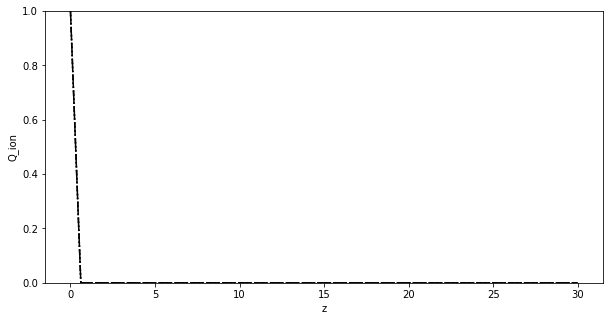

In [9]:
Q=[Qe, Qi, Ql]
line=['dotted','dashed','dashdot']
plt.figure(figsize=(10,5))
plt.ylim([0,1])
plt.xlabel('z')
plt.ylabel('Q_ion')
for i in range(len(line)):
    plt.plot(zarr,Q[i],linestyle=line[i],c='k')

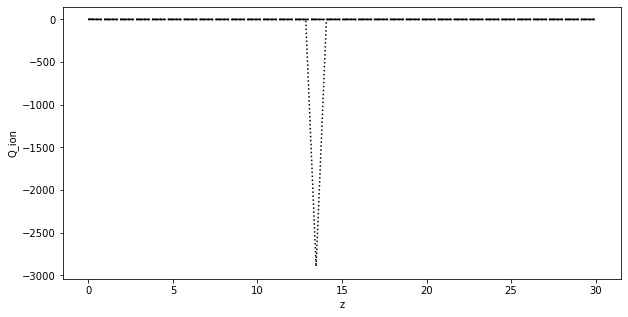

In [11]:
Q=[Qe, Qi, Ql]
line=['dotted','dashed','dashdot']
plt.figure(figsize=(10,5))
plt.xlabel('z')
plt.ylabel('Q_ion')
for i in range(len(line)):
    plt.plot(zarr,Q[i],linestyle=line[i],c='k')